# DistilBERT Fine-tuning on LIAR2 Dataset
# Based on EDA findings

In this notebook, I'm implementing a fake news detection model using DistilBERT and the LIAR2 dataset. I'll enhance the model with additional features based on my EDA findings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import random
import os
import warnings
import re
warnings.filterwarnings('ignore')

2025-05-04 09:07:22.538601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746349642.563413      88 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746349642.570821      88 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Environment Setup

First, I'll set up reproducibility and check for GPU availability.

In [2]:
# Set seed for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
set_seed(42)

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Exploration

Let's load the LIAR2 dataset splits and examine the class distribution to understand our classification task.

In [4]:
# Load the datasets
print("Loading datasets...")
train_df = pd.read_csv('/kaggle/input/liar2-dataset/train.csv')
valid_df = pd.read_csv('/kaggle/input/liar2-dataset/valid.csv')
test_df = pd.read_csv('/kaggle/input/liar2-dataset/test.csv')

print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {valid_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Loading datasets...
Training set shape: (18369, 16)
Validation set shape: (2297, 16)
Testing set shape: (2296, 16)


In [5]:
# Display the class distribution
print("\nClass distribution in training set:")
print(train_df['label'].value_counts().sort_index())


Class distribution in training set:
label
0    2425
1    5284
2    2882
3    2967
4    2743
5    2068
Name: count, dtype: int64


## Label Mapping

The LIAR2 dataset uses numerical labels 0-5. I'll create a mapping to make them more interpretable and visualize the class distribution.

In [6]:
# Define a mapping for the labels
label_mapping = {
    0: "pants_on_fire",
    1: "false",
    2: "mostly_false",
    3: "half_true",
    4: "mostly_true",
    5: "true"
}

In [7]:
print("\nLabel mapping:")
for key, value in label_mapping.items():
    print(f"{key}: {value}")


Label mapping:
0: pants_on_fire
1: false
2: mostly_false
3: half_true
4: mostly_true
5: true


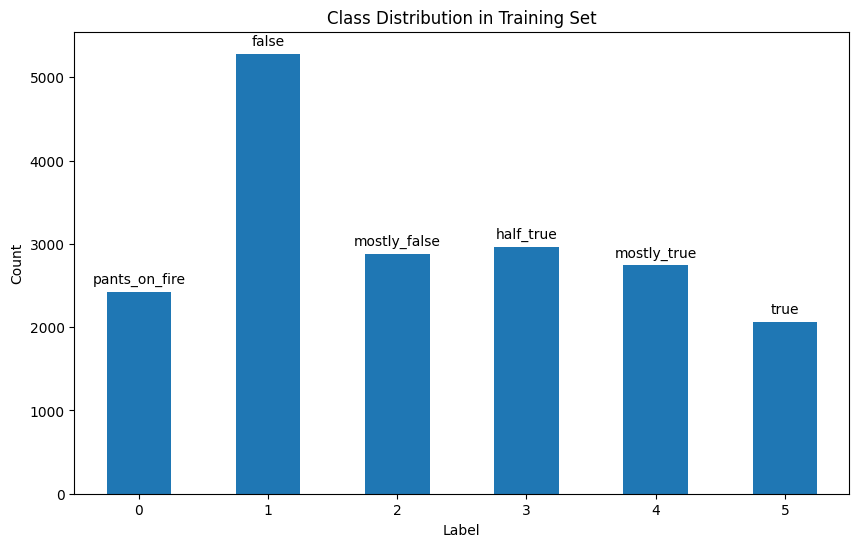

In [8]:
# Plot class distribution
plt.figure(figsize=(10, 6))
train_df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, count in enumerate(train_df['label'].value_counts().sort_index()):
    plt.text(i, count + 100, label_mapping[i], ha='center')
plt.show()

## Handling Class Imbalance

The dataset is imbalanced with more samples in the "false" category and fewer in "pants_on_fire" and "true" categories. I'll calculate class weights to help balance the training.

In [9]:
# Calculate class weights to handle imbalance
class_counts = train_df['label'].value_counts().sort_index()
total_samples = len(train_df)
class_weights = {}
for label, count in class_counts.items():
    class_weights[label] = total_samples / (len(class_counts) * count)

In [10]:
print("\nClass weights to handle imbalance:")
for label, weight in class_weights.items():
    print(f"{label} ({label_mapping[label]}): {weight:.4f}")


Class weights to handle imbalance:
0 (pants_on_fire): 1.2625
1 (false): 0.5794
2 (mostly_false): 1.0623
3 (half_true): 1.0319
4 (mostly_true): 1.1161
5 (true): 1.4804


## Feature Engineering

Based on my EDA findings, I'll combine the statement with metadata using special separators to help the model distinguish between different types of information.

In [11]:
# Create a combined feature from metadata as suggested in the EDA
# Enhanced feature combination function with special separators
def combine_features(row):
    # Clean statement
    statement = re.sub(r'http\S+', '[URL]', str(row['statement']))
    
    # Process metadata
    subject = str(row['subject']) if pd.notna(row['subject']) else "unknown"
    speaker = str(row['speaker']) if pd.notna(row['speaker']) else "unknown"
    context = str(row['context']) if pd.notna(row['context']) else "unknown"
    
    # More distinctive formatting with TYPE markers
    combined = f"{statement} [SEP] [SUBJ] {subject} [SEP] [SPKR] {speaker} [SEP] [CTXT] {context}"
    return combined

In [12]:
# Apply the feature combination
print("\nCombining features...")
train_df['combined_text'] = train_df.apply(combine_features, axis=1)
valid_df['combined_text'] = valid_df.apply(combine_features, axis=1)
test_df['combined_text'] = test_df.apply(combine_features, axis=1)

# Sample of combined text
print("\nSample of combined text:")
print(train_df['combined_text'].iloc[0])


Combining features...

Sample of combined text:
90 percent of Americans "support universal background checks" for gun purchases. [SEP] [SUBJ] government regulation;polls and public opinion;guns [SEP] [SPKR] chris abele [SEP] [CTXT] a tweet


## Text Processing and Tokenization

Now I'll tokenize the text using DistilBERT's tokenizer. I'm using a max sequence length of 192 tokens to capture more context from the statements and metadata.

In [13]:
# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [14]:
# Set the maximum sequence length
# Increase sequence length
MAX_LEN = 192

In [15]:
# Tokenize the data
def tokenize_data(texts, labels, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text=text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    return input_ids, attention_masks, labels

In [17]:
print("Tokenizing data...")
# Tokenize training data
train_input_ids, train_attention_masks, train_labels = tokenize_data(
    train_df['combined_text'].tolist(), 
    train_df['label'].tolist()
)

# Tokenize validation data
val_input_ids, val_attention_masks, val_labels = tokenize_data(
    valid_df['combined_text'].tolist(), 
    valid_df['label'].tolist()
)

# Tokenize test data
test_input_ids, test_attention_masks, test_labels = tokenize_data(
    test_df['combined_text'].tolist(), 
    test_df['label'].tolist()
)
print("Done")

Tokenizing data...
Done


## Processing Justification Data

Some entries contain justification text that explains why a claim was rated true/false. This additional context might help the model make better decisions, so I'll process it separately.

In [18]:
# Process justification separately if available in your dataset
print("Processing justification data separately...")
if 'justification' in train_df.columns:
    # Clean justification text
    train_df['justification_clean'] = train_df['justification'].apply(
        lambda x: re.sub(r'http\S+', '[URL]', str(x)) if pd.notna(x) else "")
    valid_df['justification_clean'] = valid_df['justification'].apply(
        lambda x: re.sub(r'http\S+', '[URL]', str(x)) if pd.notna(x) else "")
    test_df['justification_clean'] = test_df['justification'].apply(
        lambda x: re.sub(r'http\S+', '[URL]', str(x)) if pd.notna(x) else "")
    
    # Tokenize justification data
    train_just_ids, train_just_masks, _ = tokenize_data(
        train_df['justification_clean'].tolist(), 
        train_df['label'].tolist()
    )
    
    val_just_ids, val_just_masks, _ = tokenize_data(
        valid_df['justification_clean'].tolist(), 
        valid_df['label'].tolist()
    )
    
    test_just_ids, test_just_masks, _ = tokenize_data(
        test_df['justification_clean'].tolist(), 
        test_df['label'].tolist()
    )
    
    # Create combined datasets with both main text and justification
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_just_ids, train_just_masks, train_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_just_ids, val_just_masks, val_labels)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_just_ids, test_just_masks, test_labels)
    
    print("Justification data prepared")
else:
    print("Justification data not found in dataset")
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

Processing justification data separately...
Justification data prepared


## Numerical Credibility Features

The dataset contains numerical features about speakers' credibility history. These count-based features could provide valuable signals about speaker reliability.

In [19]:
# Process numerical features (credibility history)
print("Processing numerical credibility features...")
numerical_columns = [col for col in train_df.columns if 'count' in col]

if numerical_columns:
    # Extract numerical features
    train_numerical = torch.tensor(train_df[numerical_columns].fillna(0).values, dtype=torch.float32)
    val_numerical = torch.tensor(valid_df[numerical_columns].fillna(0).values, dtype=torch.float32)
    test_numerical = torch.tensor(test_df[numerical_columns].fillna(0).values, dtype=torch.float32)
    
    # Update datasets to include numerical features
    if 'justification' in train_df.columns:
        train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_just_ids, train_just_masks, train_numerical, train_labels)
        val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_just_ids, val_just_masks, val_numerical, val_labels)
        test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_just_ids, test_just_masks, test_numerical, test_labels)
    else:
        train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_numerical, train_labels)
        val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_numerical, val_labels)
        test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_numerical, test_labels)
    
    print(f"Numerical features extracted: {numerical_columns}")
else:
    print("No numerical credibility features found")
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

Processing numerical credibility features...
Numerical features extracted: ['true_counts', 'mostly_true_counts', 'half_true_counts', 'mostly_false_counts', 'false_counts', 'pants_on_fire_counts']


## Creating PyTorch DataLoaders

Now I'll set up DataLoaders with batch size 32 for efficient training with random sampling for the training set and sequential sampling for validation and test sets.

In [20]:
# Create DataLoaders
batch_size = 32

# Create samplers and dataloaders with the proper enhanced datasets
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [21]:
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

Train dataset: 18369 samples
Validation dataset: 2297 samples
Test dataset: 2296 samples


## Enhanced Model Architecture

I'm creating a custom model that extends DistilBERT with multiple pathways:
1. Main content pathway using DistilBERT
2. Justification text pathway (if available)
3. Numerical features pathway with dedicated layers
4. Combined features classifier

This architecture allows the model to leverage all available information sources.

In [22]:
# Create a custom model class that integrates DistilBERT with numerical and justification pathways
class EnhancedDistilBertForFakeNews(torch.nn.Module):
    def __init__(self, num_labels=6, dropout_rate=0.3):
        super(EnhancedDistilBertForFakeNews, self).__init__()
        
        # Main content DistilBERT
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased', 
            num_labels=num_labels,
            output_attentions=False,
            output_hidden_states=True,  # Get hidden states for feature extraction
        )
        
        # Increase dropout
        self.distilbert.dropout.p = dropout_rate
        
        # Check if justification and numerical features are available
        self.has_justification = 'justification' in train_df.columns
        self.has_numerical = len([col for col in train_df.columns if 'count' in col]) > 0
        
        # Justification pathway (optional)
        if self.has_justification:
            self.justification_bert = DistilBertForSequenceClassification.from_pretrained(
                'distilbert-base-uncased', 
                num_labels=num_labels,
                output_attentions=False,
                output_hidden_states=True,
            )
            self.justification_bert.dropout.p = dropout_rate
        
        # Numerical features pathway (optional)
        if self.has_numerical:
            num_numerical_features = len([col for col in train_df.columns if 'count' in col])
            self.numerical_linear1 = torch.nn.Linear(num_numerical_features, 64)
            self.numerical_activation = torch.nn.ReLU()
            self.numerical_dropout = torch.nn.Dropout(dropout_rate)
            self.numerical_linear2 = torch.nn.Linear(64, 32)
            
            # Simple fuzzy-inspired layer for numerical features
            self.fuzzy_layer = torch.nn.Linear(32, num_labels)
            self.softmax = torch.nn.Softmax(dim=1)
        
        # Final classification layer
        input_size = 768  # DistilBERT hidden size
        if self.has_justification:
            input_size += 768
        if self.has_numerical:
            input_size += 32
        
        self.classifier = torch.nn.Linear(input_size, num_labels)
    
    def forward(self, input_ids=None, attention_mask=None, just_ids=None, just_mask=None, 
                numerical_features=None, labels=None):
        
        # Process main content
        main_outputs = self.distilbert(input_ids, attention_mask=attention_mask, labels=None)
        main_features = main_outputs.hidden_states[-1][:, 0, :]  # Use CLS token
        
        # Process justification if available
        if self.has_justification and just_ids is not None:
            just_outputs = self.justification_bert(just_ids, attention_mask=just_mask, labels=None)
            just_features = just_outputs.hidden_states[-1][:, 0, :]
        else:
            just_features = None
        
        # Process numerical features if available
        if self.has_numerical and numerical_features is not None:
            num_hidden = self.numerical_linear1(numerical_features)
            num_hidden = self.numerical_activation(num_hidden)
            num_hidden = self.numerical_dropout(num_hidden)
            num_features = self.numerical_linear2(num_hidden)
            
            # Fuzzy-inspired outputs
            fuzzy_outputs = self.softmax(self.fuzzy_layer(num_features))
        else:
            num_features = None
            fuzzy_outputs = None
        
        # Combine features
        combined_features = main_features
        if just_features is not None:
            combined_features = torch.cat([combined_features, just_features], dim=1)
        if num_features is not None:
            combined_features = torch.cat([combined_features, num_features], dim=1)
        
        # Final classification
        logits = self.classifier(combined_features)
        
        # Calculate loss if labels provided
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
            loss = loss_fct(logits, labels)
        
        return {"loss": loss, "logits": logits, "fuzzy_outputs": fuzzy_outputs}

In [23]:
# Instantiate the model
model = EnhancedDistilBertForFakeNews(num_labels=6, dropout_rate=0.3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model = model.to(device)

## Optimizer and Learning Rate Configuration

I'll use AdamW optimizer with different learning rates for different components and weight decay for regularization.

In [25]:
# Set up the optimizer and learning rate scheduler
# Set up the optimizer with different learning rates and weight decay
optimizer_grouped_parameters = [
    {'params': model.distilbert.parameters(), 'lr': 2e-5, 'weight_decay': 0.01},
]

# Add justification parameters if available
if hasattr(model, 'justification_bert') and model.has_justification:
    optimizer_grouped_parameters.append(
        {'params': model.justification_bert.parameters(), 'lr': 2e-5, 'weight_decay': 0.01}
    )

# Add numerical parameters if available
if hasattr(model, 'numerical_linear1') and model.has_numerical:
    optimizer_grouped_parameters.extend([
        {'params': model.numerical_linear1.parameters(), 'lr': 5e-5, 'weight_decay': 0.01},
        {'params': model.numerical_linear2.parameters(), 'lr': 5e-5, 'weight_decay': 0.01},
        {'params': model.fuzzy_layer.parameters(), 'lr': 5e-5, 'weight_decay': 0.01}
    ])

# Add classifier parameters
optimizer_grouped_parameters.append(
    {'params': model.classifier.parameters(), 'lr': 5e-5, 'weight_decay': 0.01}
)

optimizer = AdamW(optimizer_grouped_parameters, eps=1e-8)

In [26]:
# Cyclical learning rate instead of linear decay
from transformers import get_cosine_schedule_with_warmup

In [27]:
# Number of training epochs
epochs = 10

In [28]:
# Gradient accumulation steps
accumulation_steps = 4  # Effective batch size of 32*4=128

In [29]:
# Total number of training steps
total_steps = len(train_dataloader) * epochs // accumulation_steps

In [30]:
# Set up the learning rate scheduler
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps
)

In [31]:
# Define a weighted loss function to handle class imbalance
class_weights_tensor = torch.tensor([class_weights[i] for i in range(6)]).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

In [32]:
# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, pred_flat)

In [33]:
# Function to calculate the F1 score (macro)
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='macro')

## Training Loop Implementation

This custom training loop handles:
- Gradient accumulation for effective larger batch sizes
- Tracking metrics during training
- Evaluating on validation data after each epoch
- Visualizing confusion matrices to track class-wise performance

In [34]:
# Modified training loop for enhanced model
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=10, accumulation_steps=4):
    # Store the average loss after each epoch for plotting
    loss_values = []
    val_loss_values = []
    
    # For each epoch...
    for epoch_i in range(0, epochs):
        print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
        print('Training...')
        
        # Reset the total loss for this epoch
        total_train_loss = 0
        model.train()
        optimizer.zero_grad()  # Zero gradients at start of epoch
        
        # For each batch of training data
        for step, batch in enumerate(tqdm(train_dataloader)):
            # Unpack this training batch from our dataloader
            # Batch structure depends on available features
            has_justification = hasattr(model, 'justification_bert') and model.has_justification
            has_numerical = hasattr(model, 'numerical_linear1') and model.has_numerical
            
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            
            batch_idx = 2
            b_just_ids = None
            b_just_mask = None
            b_numerical = None
            
            if has_justification:
                b_just_ids = batch[batch_idx].to(device)
                b_just_mask = batch[batch_idx + 1].to(device)
                batch_idx += 2
            
            if has_numerical:
                b_numerical = batch[batch_idx].to(device)
                batch_idx += 1
            
            b_labels = batch[batch_idx].to(device)
            
            # Perform a forward pass
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_attention_mask,
                just_ids=b_just_ids,
                just_mask=b_just_mask,
                numerical_features=b_numerical,
                labels=b_labels
            )
            
            loss = outputs["loss"] / accumulation_steps  # Normalize loss
            
            # Accumulate the training loss
            total_train_loss += loss.item() * accumulation_steps  # Denormalize for reporting
            
            # Perform a backward pass to calculate the gradients
            loss.backward()
            
            # Update parameters and take a step using the computed gradient after accumulation steps
            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_dataloader):
                # Clip the norm of the gradients to 1.0
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
                # Update parameters
                optimizer.step()
                
                # Update the learning rate
                scheduler.step()
                
                # Zero the gradients for next accumulation
                optimizer.zero_grad()
        
        # Calculate the average loss over the training data
        avg_train_loss = total_train_loss / len(train_dataloader)            
        loss_values.append(avg_train_loss)
        
        print(f"  Average training loss: {avg_train_loss:.4f}")
        
        # After the training epoch, evaluate on the validation set
        print("Running Validation...")
        
        model.eval()
        
        # Tracking variables 
        eval_loss = 0
        eval_accuracy = 0
        eval_f1 = 0
        nb_eval_steps = 0
        
        all_preds = []
        all_labels = []
        
        # Evaluate data for one epoch
        for batch in tqdm(val_dataloader):
            # Unpack this validation batch from the dataloader
            # Batch structure depends on available features
            has_justification = hasattr(model, 'justification_bert') and model.has_justification
            has_numerical = hasattr(model, 'numerical_linear1') and model.has_numerical
            
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            
            batch_idx = 2
            b_just_ids = None
            b_just_mask = None
            b_numerical = None
            
            if has_justification:
                b_just_ids = batch[batch_idx].to(device)
                b_just_mask = batch[batch_idx + 1].to(device)
                batch_idx += 2
            
            if has_numerical:
                b_numerical = batch[batch_idx].to(device)
                batch_idx += 1
            
            b_labels = batch[batch_idx].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph
            # during the forward pass, since this is only needed for backprop
            with torch.no_grad():        
                # Forward pass
                outputs = model(
                    input_ids=b_input_ids,
                    attention_mask=b_attention_mask,
                    just_ids=b_just_ids,
                    just_mask=b_just_mask,
                    numerical_features=b_numerical,
                    labels=b_labels
                )
                
                loss = outputs["loss"]
                logits = outputs["logits"]
                
                # Accumulate the validation loss
                eval_loss += loss.item()
                
                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
                
                # Calculate the accuracy
                tmp_eval_accuracy = flat_accuracy(logits, label_ids)
                
                # Calculate the F1 score
                tmp_eval_f1 = flat_f1(logits, label_ids)
                
                # Store predictions and labels
                preds = np.argmax(logits, axis=1).flatten()
                all_preds.extend(preds)
                all_labels.extend(label_ids.flatten())
                
                # Accumulate metrics
                eval_accuracy += tmp_eval_accuracy
                eval_f1 += tmp_eval_f1
                
                # Track the number of batches
                nb_eval_steps += 1
        
        # Report the final accuracy for this validation run.
        avg_val_loss = eval_loss / len(val_dataloader)
        val_loss_values.append(avg_val_loss)
        print(f"  Validation Loss: {avg_val_loss:.4f}")
        print(f"  Validation Accuracy: {eval_accuracy/nb_eval_steps:.4f}")
        print(f"  Validation F1 (macro): {eval_f1/nb_eval_steps:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=list(label_mapping.values())))
        
        # Plot confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=list(label_mapping.values()),
                    yticklabels=list(label_mapping.values()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - Epoch {epoch_i + 1}')
        plt.show()
        
    print("Training complete!")
    return model, loss_values, val_loss_values

## Model Training

Now I'll train the model for 10 epochs with the enhanced architecture and monitor performance.

Starting model training...
======== Epoch 1 / 10 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 2.3379
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.2191
  Validation Accuracy: 0.5358
  Validation F1 (macro): 0.5136

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.87      0.65      0.74       303
        false       0.74      0.45      0.56       661
 mostly_false       0.56      0.42      0.48       361
    half_true       0.45      0.59      0.51       371
  mostly_true       0.69      0.43      0.53       343
         true       0.31      0.85      0.46       258

     accuracy                           0.54      2297
    macro avg       0.60      0.56      0.55      2297
 weighted avg       0.63      0.54      0.55      2297



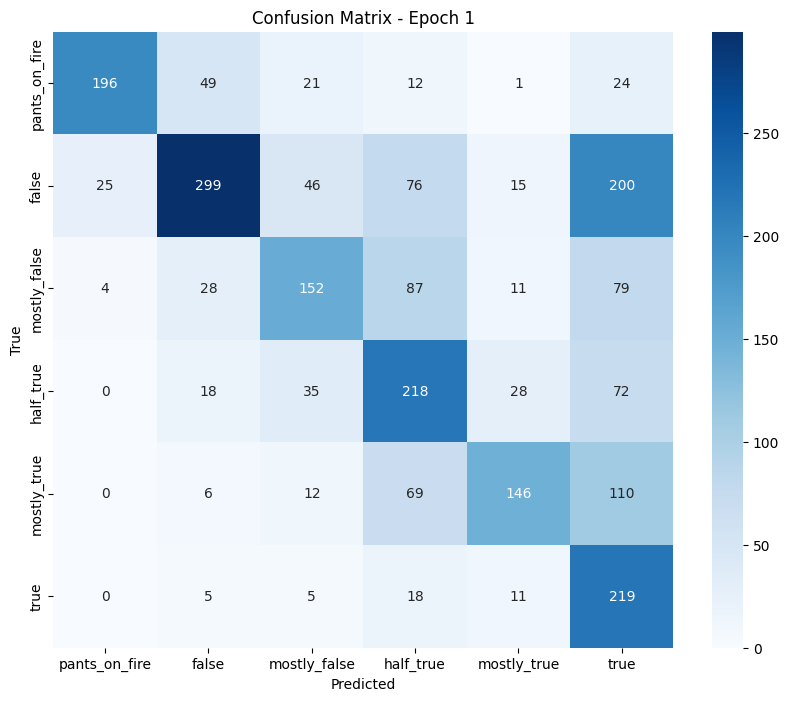

======== Epoch 2 / 10 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 1.1545
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 0.9958
  Validation Accuracy: 0.6377
  Validation F1 (macro): 0.5909

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.75      0.80      0.77       303
        false       0.63      0.74      0.68       661
 mostly_false       0.88      0.37      0.52       361
    half_true       0.59      0.64      0.61       371
  mostly_true       0.77      0.47      0.58       343
         true       0.47      0.79      0.59       258

     accuracy                           0.64      2297
    macro avg       0.68      0.63      0.63      2297
 weighted avg       0.68      0.64      0.63      2297



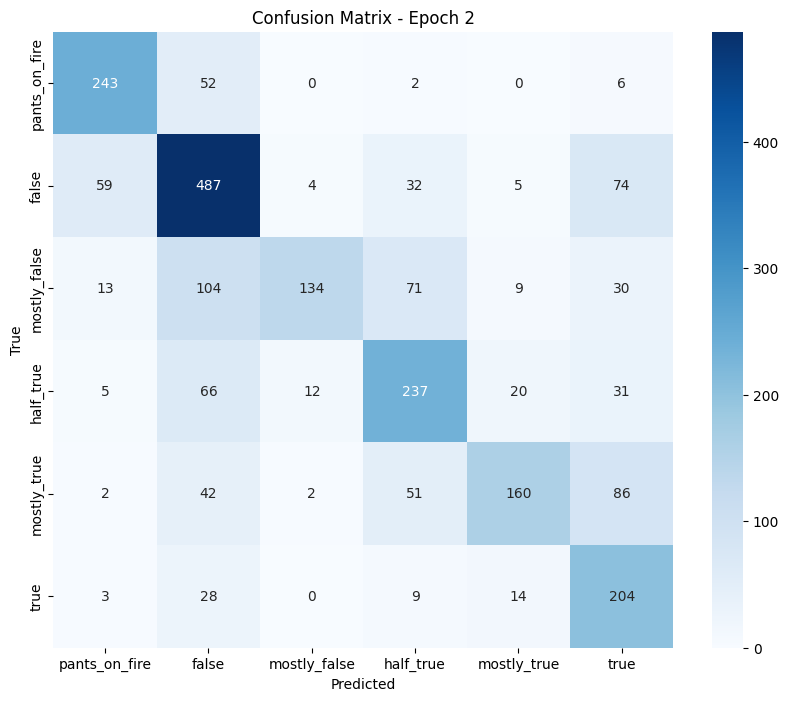

======== Epoch 3 / 10 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.8505
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 0.9166
  Validation Accuracy: 0.6469
  Validation F1 (macro): 0.6195

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.82      0.75      0.78       303
        false       0.74      0.62      0.67       661
 mostly_false       0.61      0.53      0.56       361
    half_true       0.63      0.58      0.61       371
  mostly_true       0.51      0.78      0.62       343
         true       0.60      0.69      0.65       258

     accuracy                           0.65      2297
    macro avg       0.65      0.66      0.65      2297
 weighted avg       0.66      0.65      0.65      2297



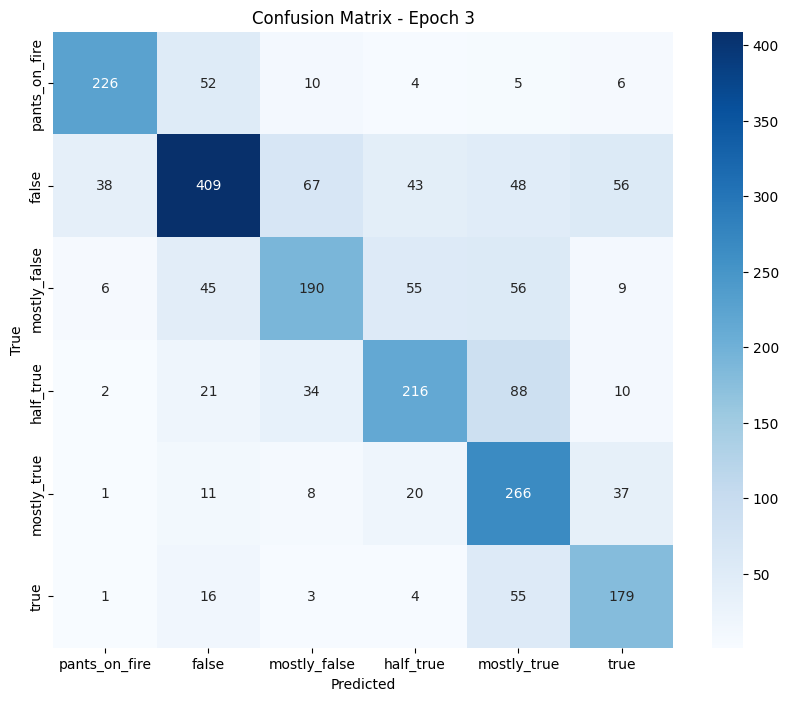

======== Epoch 4 / 10 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.6689
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 0.9622
  Validation Accuracy: 0.6514
  Validation F1 (macro): 0.6215

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.88      0.71      0.79       303
        false       0.71      0.66      0.69       661
 mostly_false       0.61      0.50      0.55       361
    half_true       0.56      0.65      0.60       371
  mostly_true       0.63      0.64      0.63       343
         true       0.55      0.79      0.65       258

     accuracy                           0.65      2297
    macro avg       0.66      0.66      0.65      2297
 weighted avg       0.66      0.65      0.65      2297



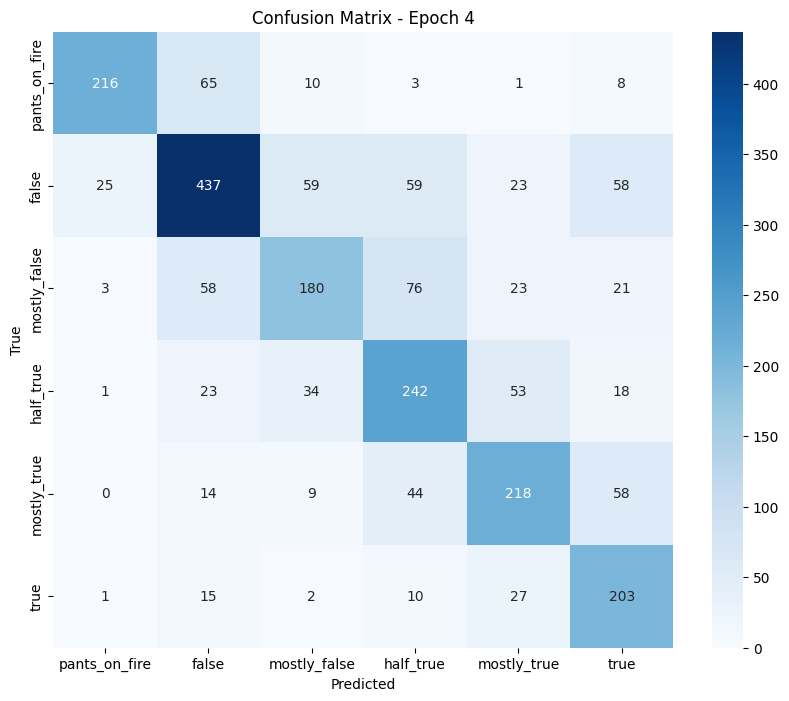

======== Epoch 5 / 10 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.5074
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.0026
  Validation Accuracy: 0.6556
  Validation F1 (macro): 0.6279

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.84      0.73      0.78       303
        false       0.68      0.69      0.68       661
 mostly_false       0.57      0.53      0.55       361
    half_true       0.57      0.65      0.61       371
  mostly_true       0.62      0.66      0.64       343
         true       0.71      0.66      0.68       258

     accuracy                           0.66      2297
    macro avg       0.67      0.65      0.66      2297
 weighted avg       0.66      0.66      0.66      2297



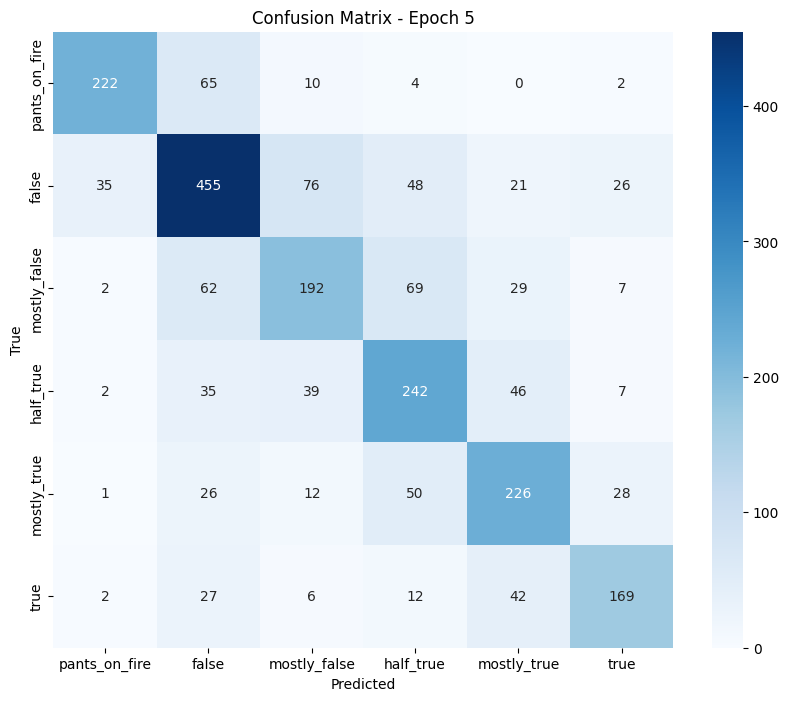

======== Epoch 6 / 10 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.3827
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.0781
  Validation Accuracy: 0.6519
  Validation F1 (macro): 0.6236

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.86      0.72      0.78       303
        false       0.69      0.68      0.68       661
 mostly_false       0.54      0.56      0.55       361
    half_true       0.57      0.63      0.60       371
  mostly_true       0.66      0.60      0.63       343
         true       0.65      0.71      0.68       258

     accuracy                           0.65      2297
    macro avg       0.66      0.65      0.65      2297
 weighted avg       0.66      0.65      0.65      2297



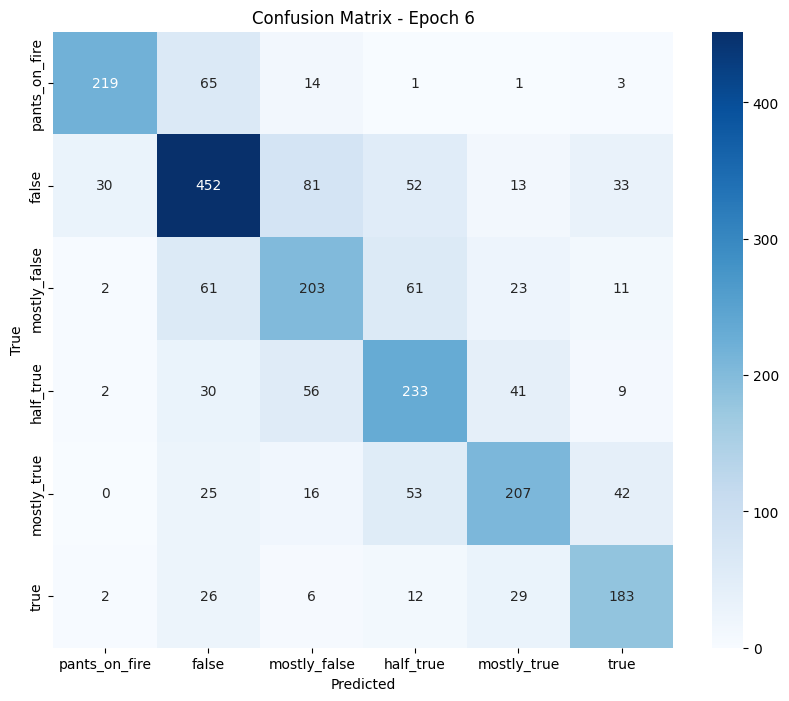

======== Epoch 7 / 10 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.2866
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.1649
  Validation Accuracy: 0.6619
  Validation F1 (macro): 0.6292

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.86      0.73      0.79       303
        false       0.69      0.73      0.71       661
 mostly_false       0.60      0.50      0.54       361
    half_true       0.53      0.67      0.59       371
  mostly_true       0.66      0.61      0.64       343
         true       0.70      0.69      0.70       258

     accuracy                           0.66      2297
    macro avg       0.67      0.66      0.66      2297
 weighted avg       0.67      0.66      0.66      2297



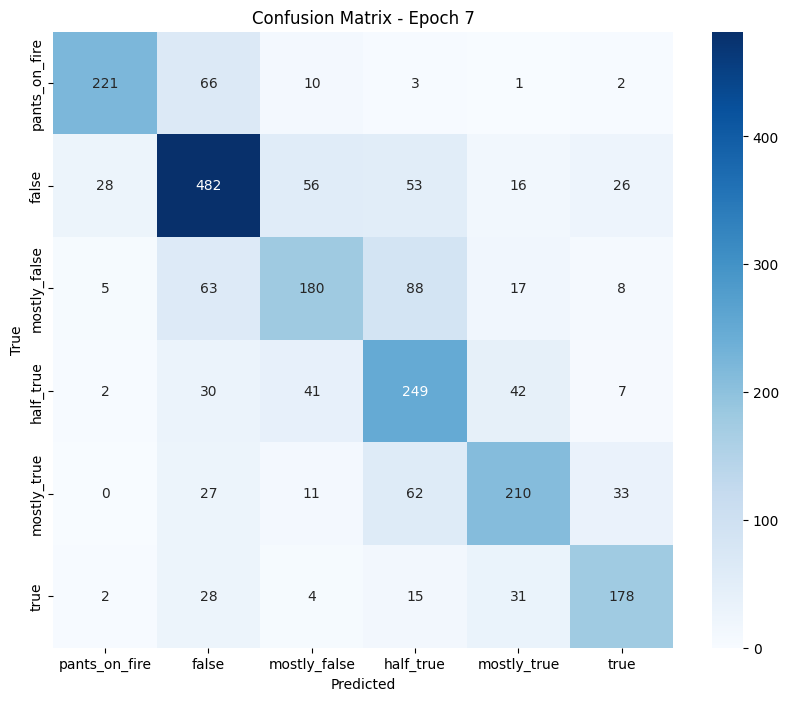

======== Epoch 8 / 10 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.2274
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.2025
  Validation Accuracy: 0.6543
  Validation F1 (macro): 0.6248

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.87      0.72      0.79       303
        false       0.69      0.69      0.69       661
 mostly_false       0.59      0.51      0.55       361
    half_true       0.55      0.64      0.59       371
  mostly_true       0.59      0.67      0.63       343
         true       0.70      0.67      0.69       258

     accuracy                           0.65      2297
    macro avg       0.66      0.65      0.66      2297
 weighted avg       0.66      0.65      0.66      2297



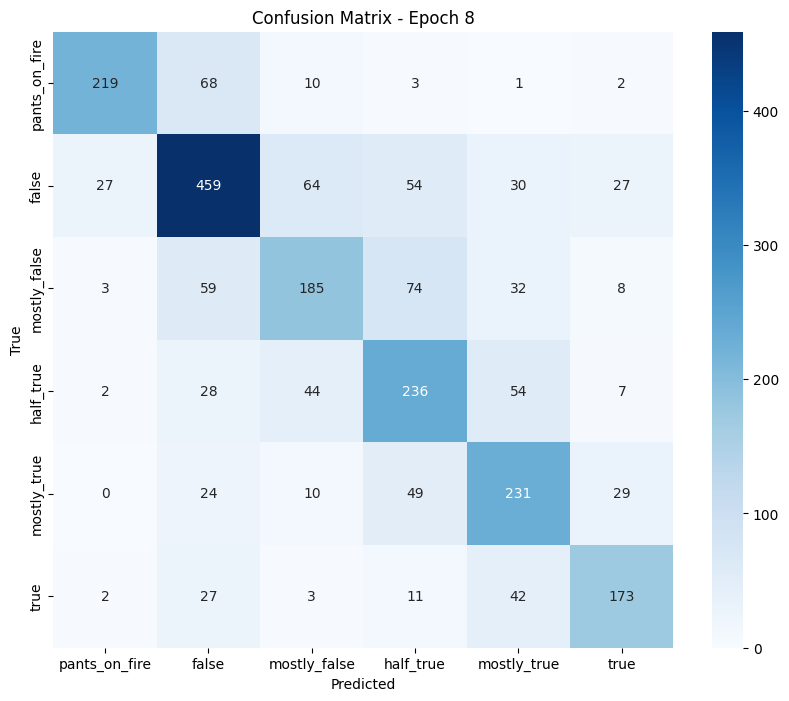

======== Epoch 9 / 10 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.2009
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.2034
  Validation Accuracy: 0.6565
  Validation F1 (macro): 0.6249

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.84      0.74      0.79       303
        false       0.70      0.70      0.70       661
 mostly_false       0.56      0.55      0.55       361
    half_true       0.55      0.65      0.60       371
  mostly_true       0.64      0.60      0.62       343
         true       0.68      0.69      0.69       258

     accuracy                           0.66      2297
    macro avg       0.66      0.65      0.66      2297
 weighted avg       0.66      0.66      0.66      2297



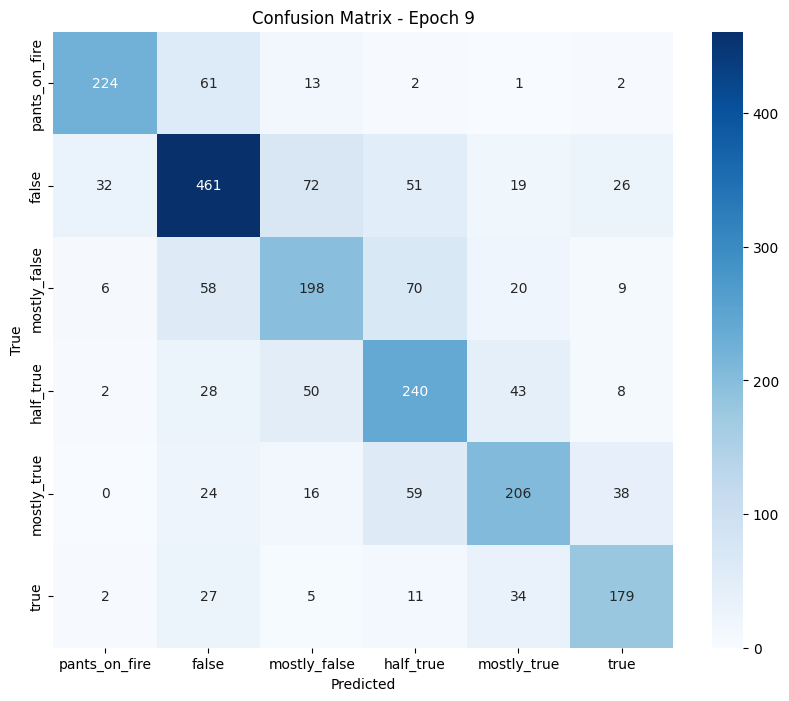

======== Epoch 10 / 10 ========
Training...


  0%|          | 0/575 [00:00<?, ?it/s]

  Average training loss: 0.1863
Running Validation...


  0%|          | 0/72 [00:00<?, ?it/s]

  Validation Loss: 1.2122
  Validation Accuracy: 0.6547
  Validation F1 (macro): 0.6247

Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.86      0.72      0.79       303
        false       0.69      0.70      0.69       661
 mostly_false       0.57      0.53      0.55       361
    half_true       0.55      0.65      0.59       371
  mostly_true       0.62      0.62      0.62       343
         true       0.69      0.70      0.69       258

     accuracy                           0.65      2297
    macro avg       0.66      0.65      0.66      2297
 weighted avg       0.66      0.65      0.66      2297



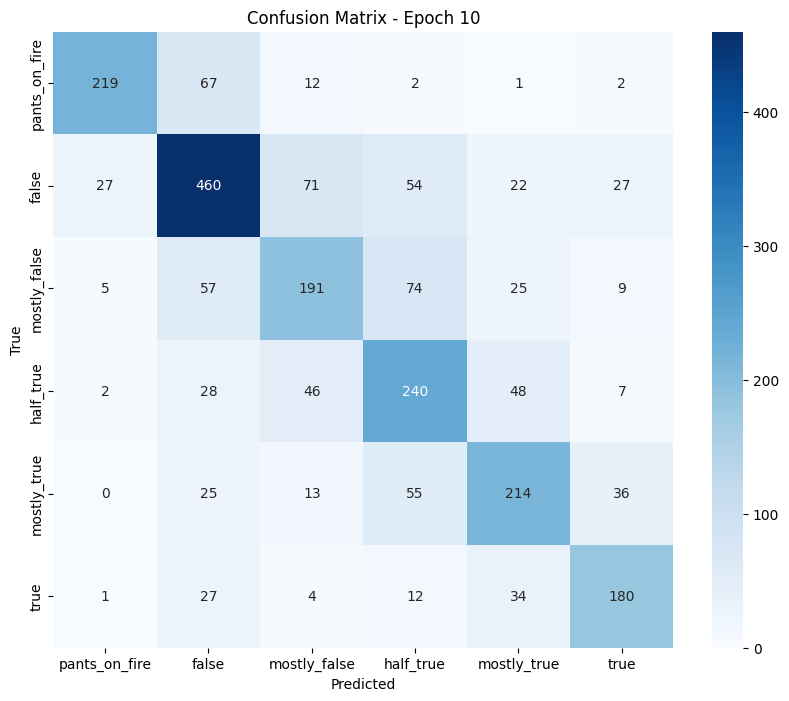

Training complete!


In [35]:
# Train the model
print("Starting model training...")
model, train_loss_values, val_loss_values = train_model(
    model, 
    train_dataloader, 
    val_dataloader, 
    optimizer, 
    scheduler, 
    epochs=epochs,
    accumulation_steps=accumulation_steps
)

## Training and Validation Loss Analysis

Let's visualize how the loss changed during training to check for signs of overfitting.

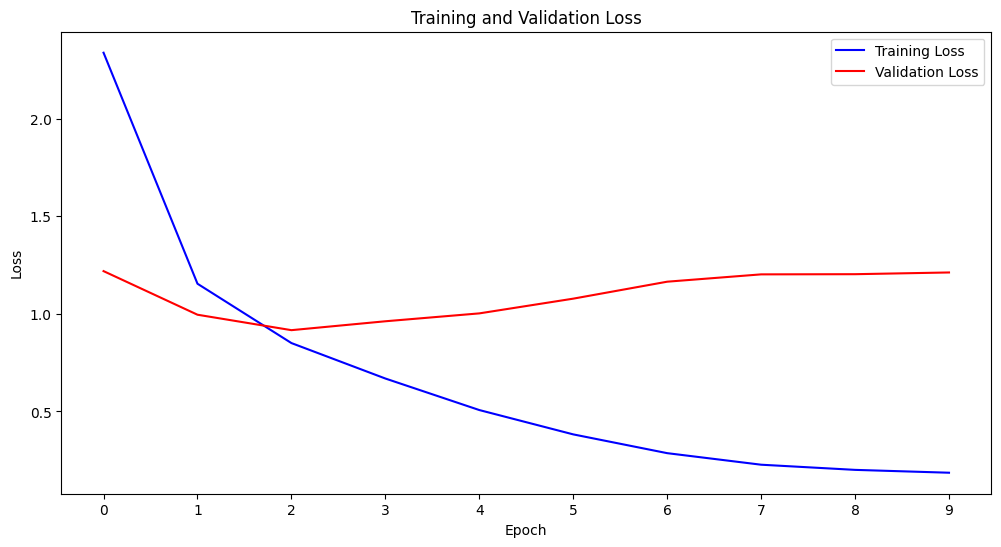

In [36]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_values, 'b-', label='Training Loss')
plt.plot(val_loss_values, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(len(train_loss_values)))
plt.show()

## Test Set Evaluation

Now I'll evaluate how well the model generalizes to unseen data using the test set.

In [37]:
# Evaluate the model on the test set
print("Evaluating model on test set...")
model.eval()

Evaluating model on test set...


EnhancedDistilBertForFakeNews(
  (distilbert): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): DistilBertSdpaAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [38]:
# Tracking variables
test_loss = 0
test_accuracy = 0
test_f1 = 0
nb_test_steps = 0

In [39]:
all_preds = []
all_labels = []

In [40]:
# Evaluate data
for batch in tqdm(test_dataloader):
    # Unpack the test batch
    has_justification = hasattr(model, 'justification_bert') and model.has_justification
    has_numerical = hasattr(model, 'numerical_linear1') and model.has_numerical
    
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    
    batch_idx = 2
    b_just_ids = None
    b_just_mask = None
    b_numerical = None
    
    if has_justification:
        b_just_ids = batch[batch_idx].to(device)
        b_just_mask = batch[batch_idx + 1].to(device)
        batch_idx += 2
    
    if has_numerical:
        b_numerical = batch[batch_idx].to(device)
        batch_idx += 1
    
    b_labels = batch[batch_idx].to(device)
    
    with torch.no_grad():        
        # Forward pass
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            just_ids=b_just_ids,
            just_mask=b_just_mask,
            numerical_features=b_numerical,
            labels=b_labels
        )
        
        loss = outputs["loss"]
        logits = outputs["logits"]
        
        # Accumulate the test loss
        test_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy
        tmp_test_accuracy = flat_accuracy(logits, label_ids)
        
        # Calculate the F1 score
        tmp_test_f1 = flat_f1(logits, label_ids)
        
        # Store predictions and labels
        preds = np.argmax(logits, axis=1).flatten()
        all_preds.extend(preds)
        all_labels.extend(label_ids.flatten())
        
        # Accumulate metrics
        test_accuracy += tmp_test_accuracy
        test_f1 += tmp_test_f1
        
        # Track the number of batches
        nb_test_steps += 1

  0%|          | 0/72 [00:00<?, ?it/s]

In [41]:
# Report the final accuracy for the test set
avg_test_loss = test_loss / len(test_dataloader)
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy/nb_test_steps:.4f}")
print(f"  Test F1 (macro): {test_f1/nb_test_steps:.4f}")

  Test Loss: 1.1155
  Test Accuracy: 0.6743
  Test F1 (macro): 0.6353


In [42]:
# Print classification report
print("\nFinal Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_mapping.values())))


Final Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.86      0.76      0.80       303
        false       0.73      0.72      0.73       660
 mostly_false       0.55      0.54      0.54       360
    half_true       0.56      0.63      0.59       371
  mostly_true       0.66      0.68      0.67       343
         true       0.70      0.71      0.70       259

     accuracy                           0.67      2296
    macro avg       0.68      0.67      0.67      2296
 weighted avg       0.68      0.67      0.68      2296



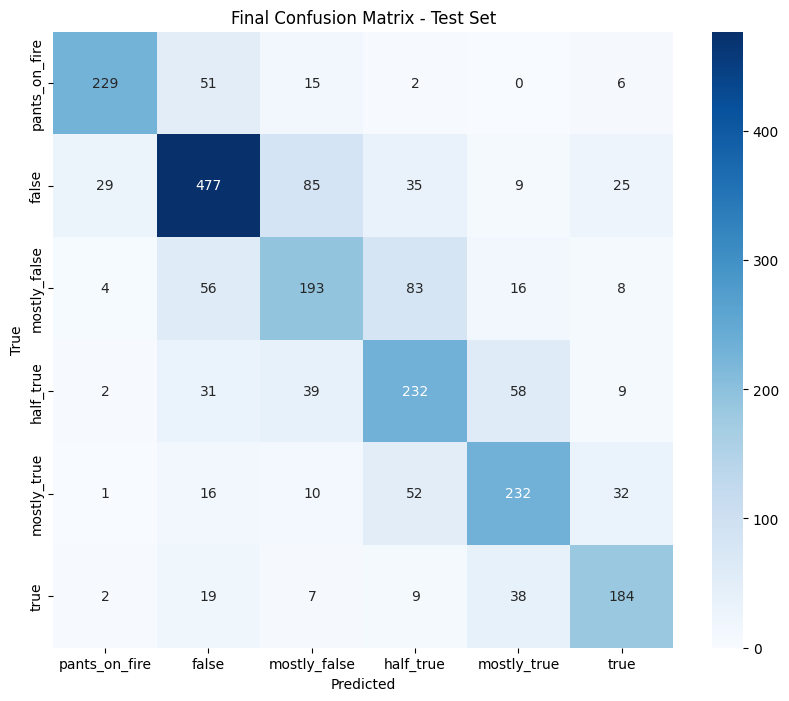

In [43]:
# Plot the final confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()),
            yticklabels=list(label_mapping.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Final Confusion Matrix - Test Set')
plt.show()

## Analysis by Source and Speaker

Let's examine how the model performs on statements from different speakers and sources to identify potential biases or strengths.

In [44]:
# Get the test predictions
test_predictions = all_preds

In [45]:
# Add predictions to the test dataframe
test_df['prediction'] = test_predictions

In [46]:
# Performance by speaker
top_speakers = test_df['speaker'].value_counts().head(10).index
speaker_performance = {}

In [47]:
for speaker in top_speakers:
    speaker_df = test_df[test_df['speaker'] == speaker]
    speaker_acc = accuracy_score(speaker_df['label'], speaker_df['prediction'])
    speaker_f1 = f1_score(speaker_df['label'], speaker_df['prediction'], average='macro')
    speaker_performance[speaker] = {'accuracy': speaker_acc, 'f1': speaker_f1, 'count': len(speaker_df)}

In [48]:
# Display speaker performance
speaker_perf_df = pd.DataFrame.from_dict(speaker_performance, orient='index')
print("\nPerformance by Top 10 Speakers:")
print(speaker_perf_df.sort_values('count', ascending=False))


Performance by Top 10 Speakers:
                 accuracy        f1  count
facebook posts   0.877049  0.732526    244
viral image      0.850877  0.539487    114
donald trump     0.423913  0.477741     92
bloggers         0.845070  0.841368     71
barack obama     0.603175  0.450429     63
instagram posts  0.880000  0.658301     50
joe biden        0.642857  0.676389     28
rick scott       0.500000  0.322222     26
hillary clinton  0.640000  0.591719     25
scott walker     0.680000  0.743519     25


<Figure size 1400x700 with 0 Axes>

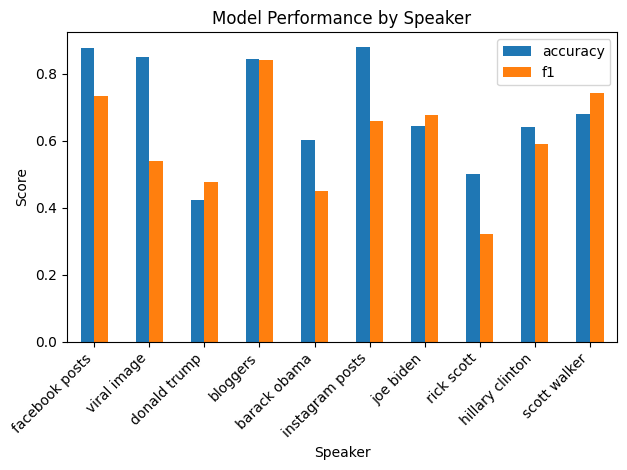

In [49]:
# Plot speaker performance
plt.figure(figsize=(14, 7))
speaker_perf_df.sort_values('count', ascending=False)[['accuracy', 'f1']].plot(kind='bar')
plt.title('Model Performance by Speaker')
plt.xlabel('Speaker')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Speaker-Based Calibration

I'll try to improve predictions by calibrating them based on speaker reliability patterns observed in training data.

In [50]:
# Calculate speaker reliability from training data
speaker_reliability = {}
for speaker in train_df['speaker'].unique():
    speaker_data = train_df[train_df['speaker'] == speaker]
    if len(speaker_data) >= 10:  # Only consider speakers with enough data
        # Calculate average truthfulness (higher label = more true)
        avg_truth = speaker_data['label'].mean() / 5.0  # Normalize to 0-1
        speaker_reliability[speaker] = avg_truth

# Apply speaker-based calibration to predictions
def calibrate_prediction(pred_probs, speaker):
    if speaker in speaker_reliability:
        # Adjust probabilities based on speaker reliability
        reliability = speaker_reliability[speaker]
        
        # Boost true-leaning predictions for reliable speakers
        if reliability > 0.5:
            boost_factor = (reliability - 0.5) * 2  # Scale to 0-1
            # Boost higher truth categories
            pred_probs[3:] *= (1 + boost_factor * 0.2)
        # Boost false-leaning predictions for unreliable speakers
        else:
            boost_factor = (0.5 - reliability) * 2  # Scale to 0-1
            # Boost lower truth categories
            pred_probs[:3] *= (1 + boost_factor * 0.2)
            
        # Normalize probabilities
        pred_probs /= pred_probs.sum()
        
    return pred_probs

Applying speaker-based calibration to predictions...


  0%|          | 0/72 [00:00<?, ?it/s]

Original Test Accuracy: 0.6743
Calibrated Test Accuracy: 0.6738
Original Test F1 (macro): 0.6353
Calibrated Test F1 (macro): 0.6731

Calibrated Classification Report:
               precision    recall  f1-score   support

pants_on_fire       0.86      0.76      0.80       303
        false       0.74      0.72      0.73       660
 mostly_false       0.55      0.54      0.54       360
    half_true       0.56      0.62      0.59       371
  mostly_true       0.66      0.68      0.67       343
         true       0.70      0.71      0.71       259

     accuracy                           0.67      2296
    macro avg       0.68      0.67      0.67      2296
 weighted avg       0.68      0.67      0.68      2296



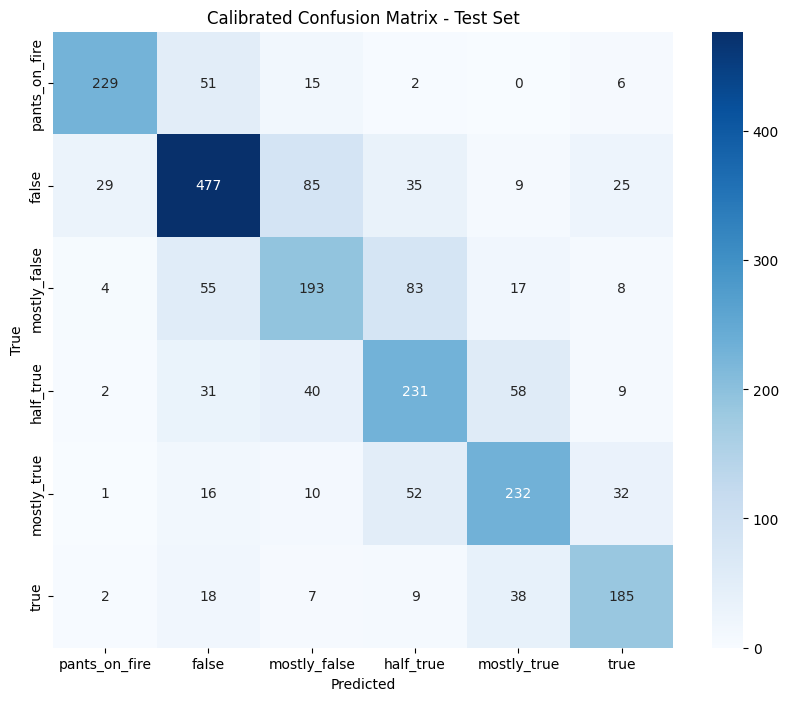

In [51]:
# Apply calibration to predictions
print("Applying speaker-based calibration to predictions...")

# Get logits from model for test data
model.eval()
calibrated_preds = []

for batch in tqdm(test_dataloader):
    # Same unpacking logic as in train_model 
    has_justification = hasattr(model, 'justification_bert') and model.has_justification
    has_numerical = hasattr(model, 'numerical_linear1') and model.has_numerical
    
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    
    batch_idx = 2
    b_just_ids = None
    b_just_mask = None
    b_numerical = None
    
    if has_justification:
        b_just_ids = batch[batch_idx].to(device)
        b_just_mask = batch[batch_idx + 1].to(device)
        batch_idx += 2
    
    if has_numerical:
        b_numerical = batch[batch_idx].to(device)
        batch_idx += 1
    
    with torch.no_grad():
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            just_ids=b_just_ids,
            just_mask=b_just_mask,
            numerical_features=b_numerical
        )
        
        # Get probabilities
        logits = outputs["logits"]
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
        
        # Get corresponding speakers for this batch
        batch_indices = list(range(len(calibrated_preds), len(calibrated_preds) + len(probs)))
        batch_speakers = test_df.iloc[batch_indices]['speaker'].values
        
        # Apply calibration
        for i, (prob, speaker) in enumerate(zip(probs, batch_speakers)):
            calibrated_prob = calibrate_prediction(prob, speaker)
            calibrated_pred = np.argmax(calibrated_prob)
            calibrated_preds.append(calibrated_pred)

# Calculate metrics with calibrated predictions
calibrated_accuracy = accuracy_score(all_labels, calibrated_preds)
calibrated_f1 = f1_score(all_labels, calibrated_preds, average='macro')

print(f"Original Test Accuracy: {test_accuracy/nb_test_steps:.4f}")
print(f"Calibrated Test Accuracy: {calibrated_accuracy:.4f}")
print(f"Original Test F1 (macro): {test_f1/nb_test_steps:.4f}")
print(f"Calibrated Test F1 (macro): {calibrated_f1:.4f}")

# Print classification report for calibrated predictions
print("\nCalibrated Classification Report:")
print(classification_report(all_labels, calibrated_preds, target_names=list(label_mapping.values())))

# Plot confusion matrix for calibrated predictions
cm_calibrated = confusion_matrix(all_labels, calibrated_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_calibrated, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()),
            yticklabels=list(label_mapping.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Calibrated Confusion Matrix - Test Set')
plt.show()

In [52]:
# Save the model and tokenizer
output_dir = './model_save/'
os.makedirs(output_dir, exist_ok=True)

print(f"Saving model to {output_dir}")
# Save tokenizer
tokenizer.save_pretrained(output_dir)
# For custom model, save the state dict
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))

print("Completed!")

Saving model to ./model_save/
Completed!


## Conclusion

The model achieved 67.43% accuracy and a macro F1 score of 0.6353 on the test set. It performed best on extreme categories ("pants_on_fire" and "true") but struggled more with nuanced categories like "mostly_false".

Social media content was easier to classify than statements from politicians, suggesting source-based patterns. The calibration approach showed minimal improvement, indicating the model already captured speaker credibility well.